In [1]:
#Importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import pickle
from geopy.distance import geodesic

In [2]:
#!conda install -c conda-forge folium --yes 

In [3]:
#!conda install -c conda-forge xgboost --yes 

In [4]:
#!conda install -c conda-forge geopy --yes 

In [5]:
# Importing Training and Test Data
train = pd.read_csv("train_cab.csv")
test = pd.read_csv("test.csv")

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16043 non-null object
pickup_datetime      16067 non-null object
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: float64(5), object(2)
memory usage: 878.7+ KB


### Converting pickup_datetime from object to Datetime object

In [7]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC',errors= "coerce")
train.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [8]:
train['fare_amount']=pd.to_numeric (train['fare_amount'], errors = "coerce")

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 7 columns):
fare_amount          16042 non-null float64
pickup_datetime      16066 non-null datetime64[ns]
pickup_longitude     16067 non-null float64
pickup_latitude      16067 non-null float64
dropoff_longitude    16067 non-null float64
dropoff_latitude     16067 non-null float64
passenger_count      16012 non-null float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 878.7 KB


In [10]:
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,16042.000000,16067.000000,16067.000000,16067.000000,16067.000000,16012.000000
mean,15.015004,-72.462787,39.914725,-72.462328,39.897906,2.625070
std,430.460945,10.578384,6.826587,10.575062,6.187087,60.844122
min,-3.000000,-74.438233,-74.006893,-74.429332,-74.006377,0.000000
25%,6.000000,-73.992156,40.734927,-73.991182,40.734651,1.000000
50%,8.500000,-73.981698,40.752603,-73.980172,40.753567,1.000000
75%,12.500000,-73.966838,40.767381,-73.963643,40.768013,2.000000
max,54343.000000,40.766125,401.083332,40.802437,41.366138,5345.000000


In the fare amount we can see the max aount charged is 54343 which is way above the 75% of 12.50. So t is clearly an outlier. Let us find such cases and remove them. Also there are some negative values. which is not possible as the fare can never be a negative figure.

### Create datetime features based on pickup_datetime

In [11]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].dt.weekday_name
train['pickup_month']=train['pickup_datetime'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_datetime'].apply(lambda x:x.year)

In [12]:
train.pickup_day_of_week.head()

0    Monday  
1    Tuesday 
2    Thursday
3    Saturday
4    Tuesday 
Name: pickup_day_of_week, dtype: object

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16067 entries, 0 to 16066
Data columns (total 13 columns):
fare_amount           16042 non-null float64
pickup_datetime       16066 non-null datetime64[ns]
pickup_longitude      16067 non-null float64
pickup_latitude       16067 non-null float64
dropoff_longitude     16067 non-null float64
dropoff_latitude      16067 non-null float64
passenger_count       16012 non-null float64
pickup_date           16066 non-null object
pickup_day            16066 non-null float64
pickup_hour           16066 non-null float64
pickup_day_of_week    16066 non-null object
pickup_month          16066 non-null float64
pickup_year           16066 non-null float64
dtypes: datetime64[ns](1), float64(10), object(2)
memory usage: 1.6+ MB


### Check for Missing Values

In [14]:
train.isnull().sum()

fare_amount           25
pickup_datetime       1 
pickup_longitude      0 
pickup_latitude       0 
dropoff_longitude     0 
dropoff_latitude      0 
passenger_count       55
pickup_date           1 
pickup_day            1 
pickup_hour           1 
pickup_day_of_week    1 
pickup_month          1 
pickup_year           1 
dtype: int64

As we can see there are couple of missing values in the dataset

In [15]:
train.replace('', np.nan, inplace = True)

AS we can see that 'pickup_datetime' is missing in only 1 row, we are dropping the same

In [16]:
train = train.dropna(axis=0, subset=['pickup_datetime'])

For the Fare amount we have filled up the same with Mean or Average of the Column.

In [17]:
train['fare_amount'].fillna((train['fare_amount'].mean()), inplace=True)

For Passenger count we have filled missing values with Zero as these might be trips where the passenger booked and cancelled and had to pay for the booking charge

In [18]:
train['passenger_count'].fillna(0, inplace=True)

## Exploratory Data Analysis

#### Distribution of Trip Fare

Text(0.5, 1.0, 'Distribution of Trip Fare')

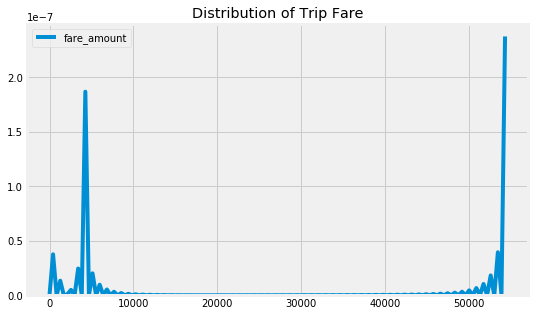

In [19]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['fare_amount']).set_title("Distribution of Trip Fare")

As we can see that the distribution is skewed. Though there doesnot seem to be negative fare amounts in the data.

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution

In [20]:
train.loc[train['fare_amount']<0].shape

(3, 13)

But we can see that there are does exist fare amount below than 0 which doesnot make sense. We will remove these for better analysis.

In [21]:
train.loc[train['fare_amount']>100].shape

(9, 13)

In [22]:
train=train.loc[train['fare_amount'].between(0,100)]

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

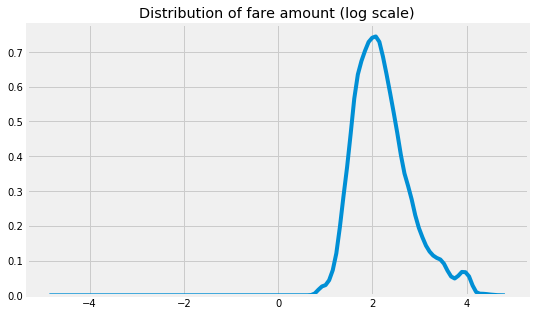

In [23]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

As we can see that the most fares are between 1 and 4. Median fare is around 2 (Currency being not mentioned in the data, is also not mentioned anywhere in the analysis)

### Let us look at Geographical Features and their relationship with Fare Amount

#### Distribution of Pickup and Dropoff Lat Lng

In [24]:
print("Range of Pickup Latitude is ", (min(train['pickup_latitude']),max(train['pickup_latitude'])))

Range of Pickup Latitude is  (-74.006893, 401.083332)


In [25]:
print("Range of Dropoff Latitude is ", (min(train['dropoff_latitude']),max(train['dropoff_latitude'])))

Range of Dropoff Latitude is  (-74.006377, 41.366138)


As we can see that the data corresponds to the Taxi rides taken in NYC whose centre lat and lon is (40, -74)

From the range of the Pickup latitude we find that there are outliers in the data.

In [26]:
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.

print("Longitude Boundary in test data")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [27]:
print("Latitude Boundary in test data")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

Let us set the boundary for the train data also based on test data lat lng boundaries.We will mark the outlier locations as 1 and remove them for further analysis

In [28]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}

There are a lot of cases where lat lng is zero. How many such cases are there in the data?

In [29]:
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(313, 13)

313 records have either pickup/dropoff lat/lng as 0.0 . There is a high chance this is present in test data as well. So, let us create a field called is_outlier_loc and mark as 1 in case it is an outlier. We will also drop all rows where the pickup or dropoff location is an outlier

In [30]:
train.loc[~((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    15702
1.0    352  
Name: is_outlier_loc, dtype: int64


### Plot Heatmap of Pickups and Dropoffs

(-74.03, -73.75)

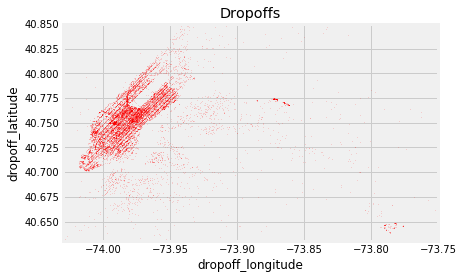

In [31]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='red', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

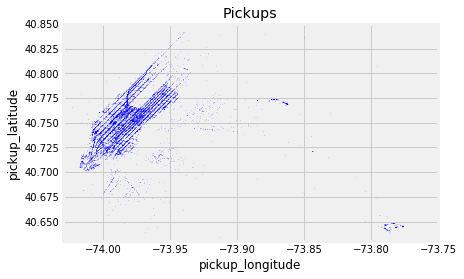

In [32]:
train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

#### Heatmap based on fare amount 

In [33]:
# Let us round pickup and dropoff lat lng to 3 decimal places
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))

In [34]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,40.604,-73.780,5.5
1,40.609,-74.090,7.7
2,40.615,-73.944,5.5
3,40.617,-73.929,12.5
4,40.620,-73.960,8.5


#### In the scatter plot, we saw the high density of pickups and dropoffs from and to JFK and La Guardia Airport

Let us look at over time how fares are from La Guardia and JFK

In [35]:
JFK={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
JFK_center=[40.6437,-73.7900]
# Get all pickups to JFK
JFK_data=train.loc[(train.pickup_latitude>=JFK['min_lat']) & (train.pickup_latitude<=JFK['max_lat'])]
JFK_data=JFK_data.loc[(train.pickup_longitude>=JFK['min_lng']) & (train.pickup_longitude<=JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=train.loc[(train.dropoff_latitude>=JFK['min_lat']) & (train.dropoff_latitude<=JFK['max_lat'])]
JFK_dropoff=JFK_dropoff.loc[(train.dropoff_longitude>=JFK['min_lng']) & (train.dropoff_longitude<=JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])

Number of Trips with Pickups from JFK 243
Number of Trips with Dropoffs to JFK 118


In [36]:
# Create a folium map with JFK as the center 
m=folium.Map(location =JFK_center,zoom_start = 10,)
folium.Marker(location=JFK_center, popup='JFK Airport',icon=folium.Icon(color='black')).add_to(m)

#mc = MarkerCluster().add_to(m)
#Add markers in blue for each pickup location and line between JFK and Pickup location over time. The thickness of line indicates the fare_amount

for index,row in JFK_data.iterrows():
    folium.Marker([row['dropoff_latitude'],row['dropoff_longitude']]).add_to(m)

#### What is the Average Fare amount of trips from JFK

Text(0.5, 1.0, 'Fare Amount Distribution')

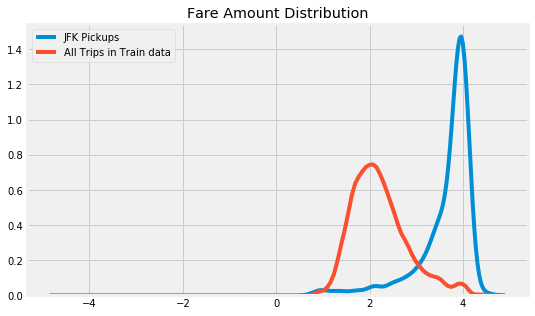

In [37]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_data['fare_amount'].values),label='JFK Pickups')
#sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")

As we can see, the fare amount is much higher when pickup is from JFK.

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

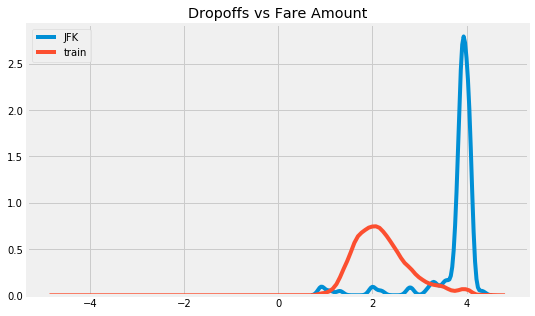

In [38]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK')
sns.kdeplot(np.log(train['fare_amount'].values),label='train')
plt.title("Dropoffs vs Fare Amount")

Distribution of fare for both pickup and drop to JFK is similar

In [39]:
del JFK_data
del JFK
del JFK_dropoff

### Based on the above, let us create a function to see whether pickup or dropoff is an Airport. 


In [40]:

def isAirport(latitude,longitude,airport_name='JFK'):
    if airport_name=='JFK':
        boundary={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
    elif airport_name=='EWR':
        boundary={
            'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        }
    elif airport_name=='la guardia':
        boundary={'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
                 }
    if latitude>=boundary['min_lat'] and latitude<=boundary['max_lat']:
        if longitude>=boundary['min_lng'] and longitude<=boundary['max_lng']:
            return 1
    else:
        return 0
        




nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0

In [41]:
train['is_pickup_JFK']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train['is_dropoff_JFK']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [42]:
train['is_pickup_EWR']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train['is_dropoff_EWR']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [43]:
train['is_pickup_la_guardia']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
train['is_dropoff_la_guardia']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

#### Trip Distance

In [44]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [45]:
train['trip_distance']=train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

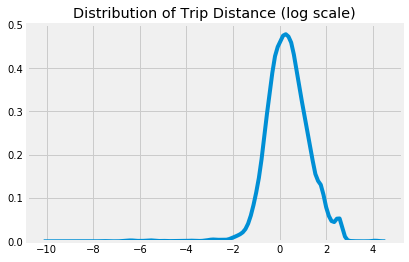

In [46]:
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0, 0.5, 'Fare Amount')

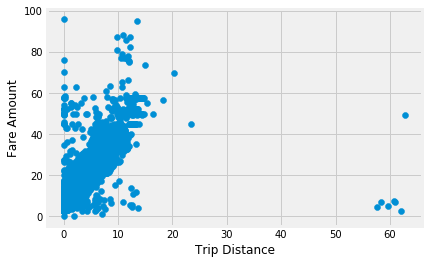

In [47]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")

From the above we are not able to find any considerate amount as fixed for the rides. However, as we know that aiports most of the time have fixed charges we can remove airport pickup and drop and plot the distribution of Fare Amount vs Trip Distribution.

In [48]:
non_airport=train.loc[(train['is_dropoff_JFK']==0) & (train['is_dropoff_EWR']==0) & (train['is_dropoff_la_guardia']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK']==0) & (non_airport['is_pickup_EWR']==0) & (non_airport['is_pickup_la_guardia']==0)]
non_airport.shape

(14810, 24)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

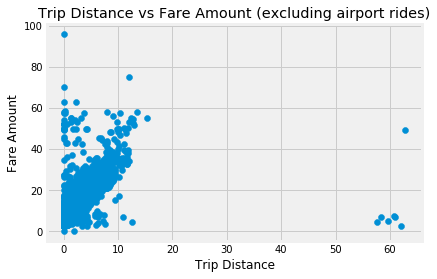

In [49]:
plt.scatter(x=non_airport['trip_distance'],y=non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

In the plot above we can see 2 clusters. But we see that the fare amount for distance above 50 miles is very very less. Let us check where these trips originate and ends.

In [50]:
non_airport_long_trips=non_airport[non_airport['trip_distance']>=50]

In [51]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
#print(pickup.shape)
### For each pickup point add a circlemarker

for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)

'''

drop_map

Most of the long trips dropoffs and pickups are in lower Manhattan.

New York city is divided into 5 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare

In [52]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}

In [53]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [54]:
train['pickup_borough']=train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['dropoff_borough']=train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

In [55]:
train.to_csv("Training_FeatureEngineering.csv",index=False)
del train

### How does the tripfare vary across buroughs

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

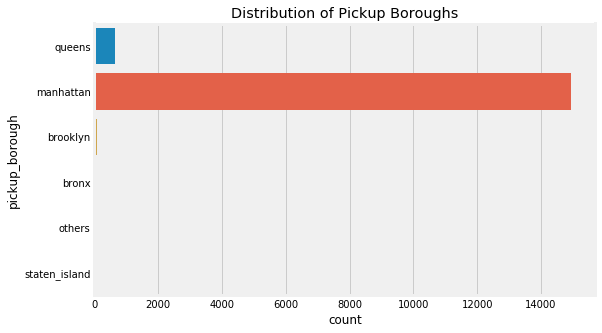

In [56]:
train=pd.read_csv("Training_FeatureEngineering.csv")
plt.figure(figsize=(8,5))
sns.countplot(y=train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

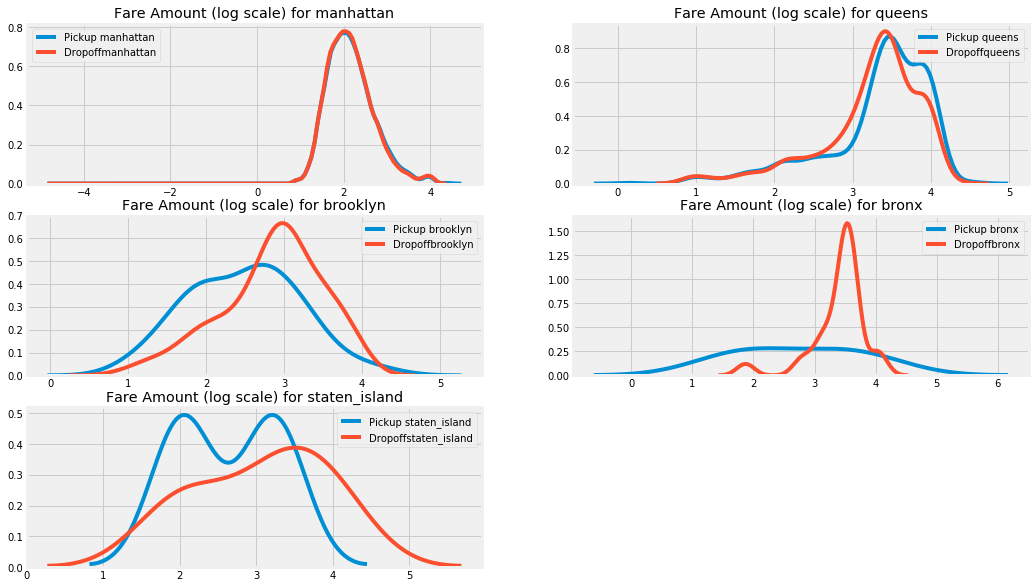

In [57]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1

There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan. We can see pickups from Staten ISland is expensive compared to pickups from Others.Very high difference in pickup and dropoff prices for Staten Island and Bronx.

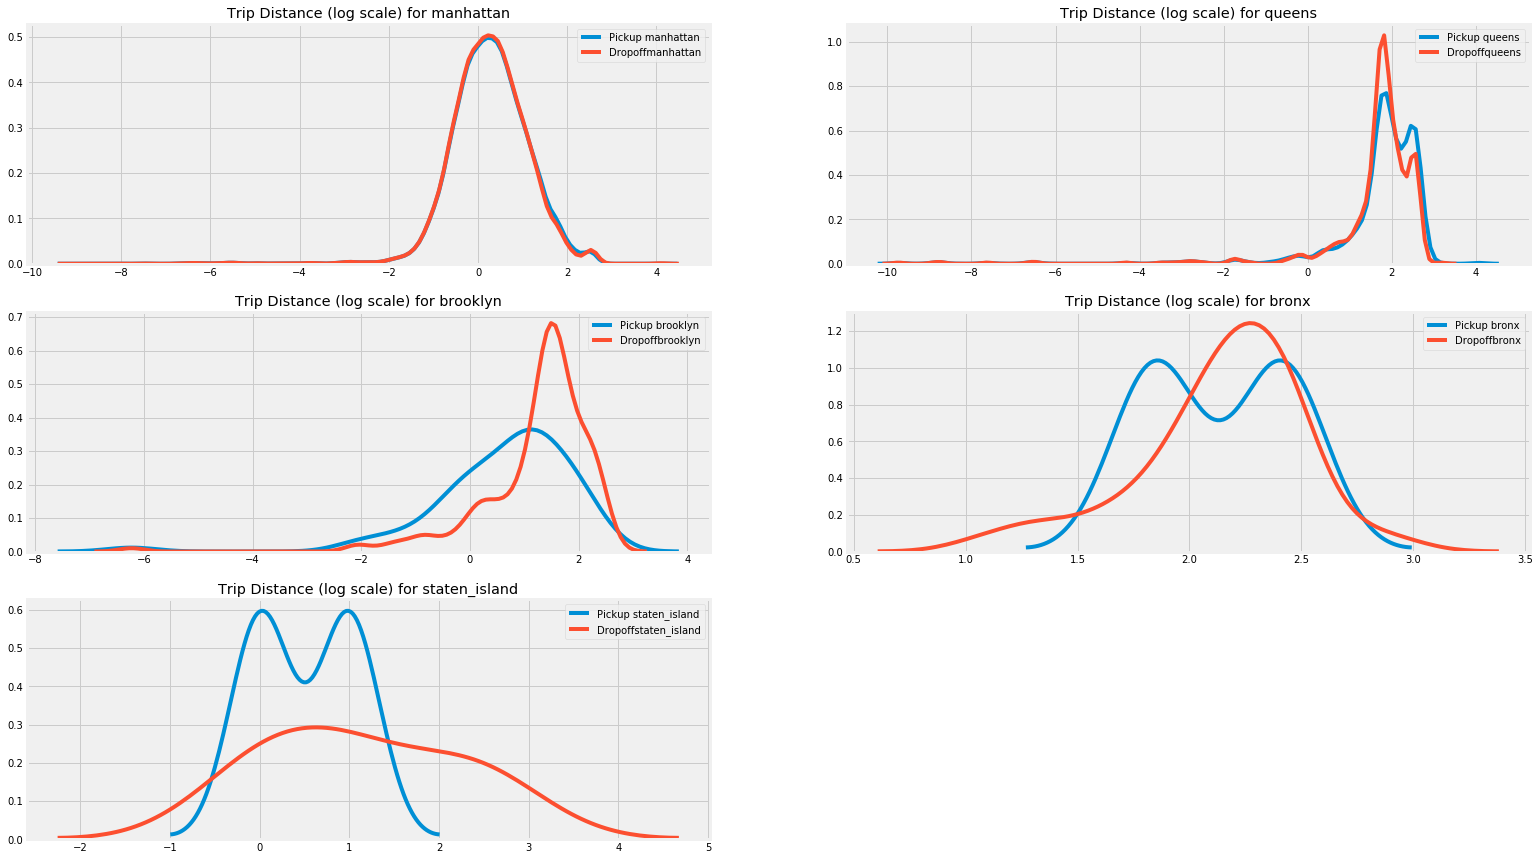

In [58]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

Dropoffs to Brooklyn, Bronx and Staten island are long trips. In Manhattan the pickup and dropoffs fare amount has similar distribution. Let us add a field, is_lower_manhattan as we had seen above that dropoffs to lower manhattan had higher trip distance but lower fare

In [59]:
lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0

In [60]:
train['is_pickup_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['is_dropoff_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

#### How does Fare Amount differ for pickups and dropoff for Lower Manhattan compared to rest of Manhattan

In [61]:
manhattan=train.loc[(train['pickup_borough']=='manhattan') | (train['dropoff_borough']=='manhattan')]
manhattan.shape

(15464, 28)

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

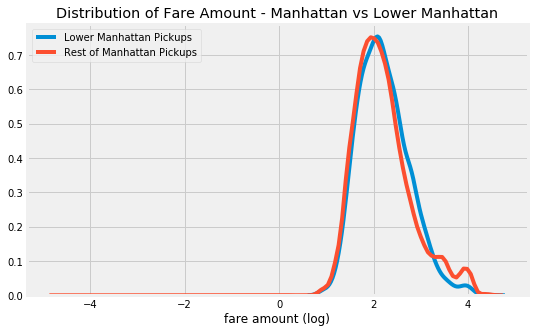

In [62]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Pickups')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Pickups')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

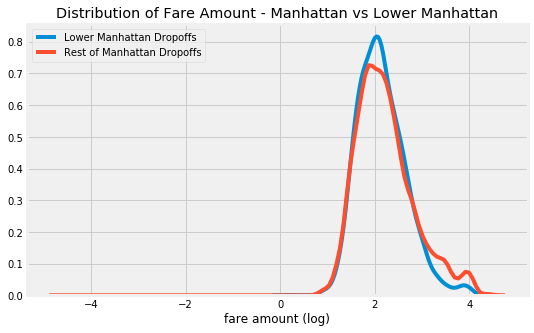

In [63]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Dropoffs')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Dropoffs')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

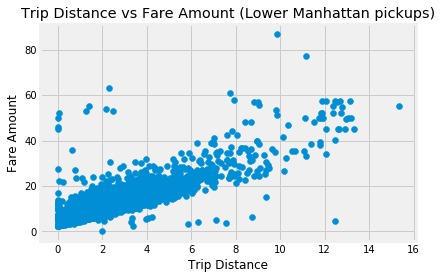

In [64]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

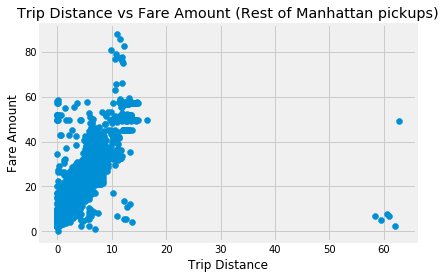

In [65]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

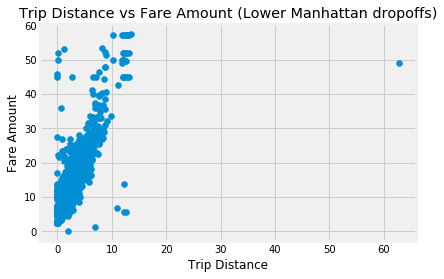

In [66]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)')

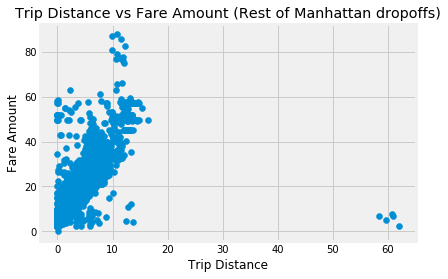

In [67]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")

In [68]:
del manhattan
del non_airport_long_trips
del non_airport

The distribution of trip distance and fare amount for Lower Manhattan pickups and dropoffs is very similar.

### Let us now look at datetime features and their realtionship with Fare Amount

#### What is the time period in our data

In [69]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 28 columns):
fare_amount                   15702 non-null float64
pickup_datetime               15702 non-null object
pickup_longitude              15702 non-null float64
pickup_latitude               15702 non-null float64
dropoff_longitude             15702 non-null float64
dropoff_latitude              15702 non-null float64
passenger_count               15702 non-null float64
pickup_date                   15702 non-null object
pickup_day                    15702 non-null float64
pickup_hour                   15702 non-null float64
pickup_day_of_week            15702 non-null object
pickup_month                  15702 non-null float64
pickup_year                   15702 non-null float64
pickup_latitude_round3        15702 non-null float64
pickup_longitude_round3       15702 non-null float64
dropoff_latitude_round3       15702 non-null float64
dropoff_longitude_round3      15702 non-null f

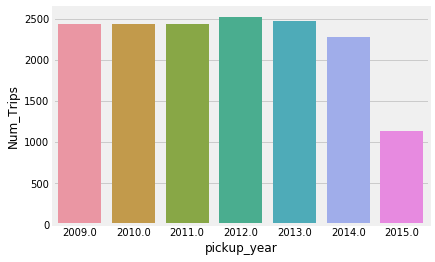

In [70]:
trips_year=train.groupby(['pickup_year'])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'Num_Trips'})
trips_year.head()
sns.barplot(x='pickup_year',y='Num_Trips',data=trips_year)

In [71]:
trips_year_fareamount=train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

Text(0.5, 1.0, 'Avg Fare Amount over Years')

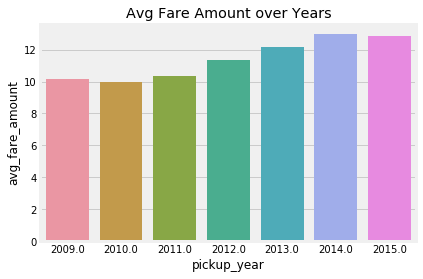

In [72]:
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

Avg Fare amount has beern increasing over the years.

In [73]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['pickup_datetime'].count().reset_index().rename(columns={'pickup_datetime':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

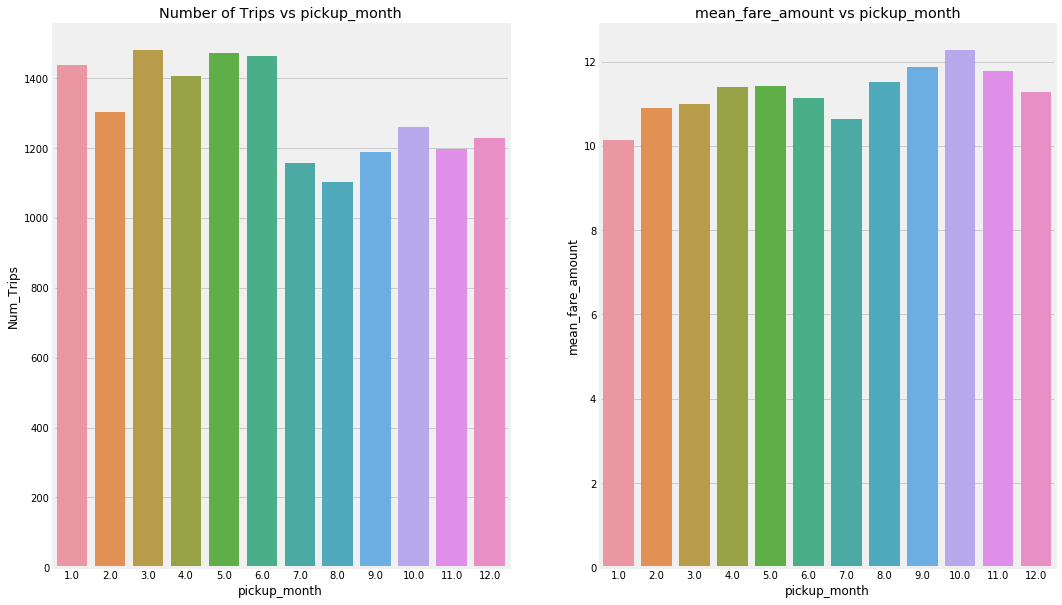

In [74]:
groupandplot(train,'pickup_month','fare_amount')

Fares across months are fairly constant apart from February, though number of trips are lower from june to decemeber

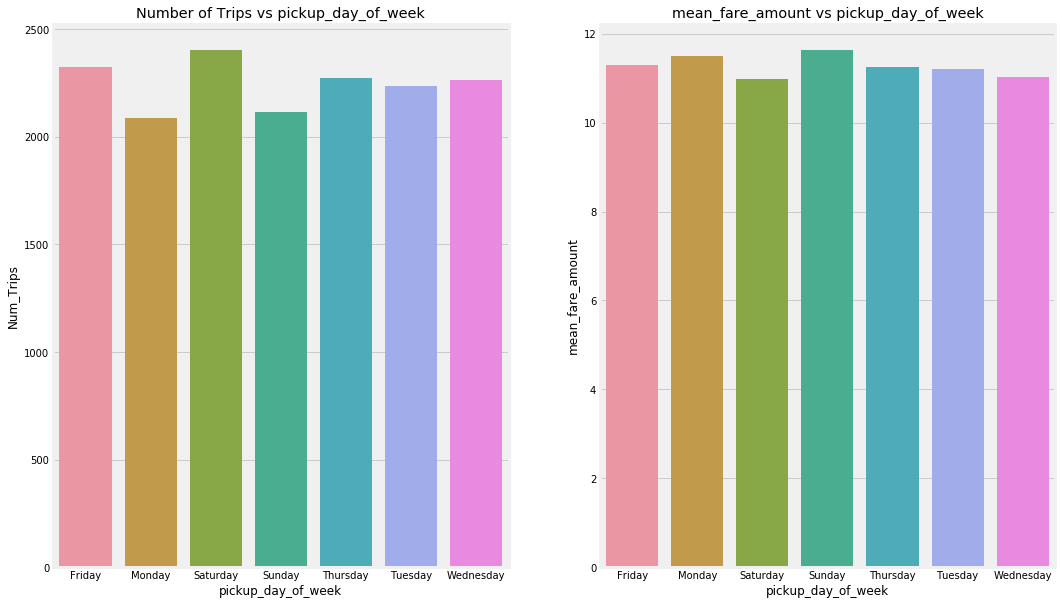

In [75]:
groupandplot(train,'pickup_day_of_week','fare_amount')

Friday seems to have a very high mean average fare and also a lot of trips.

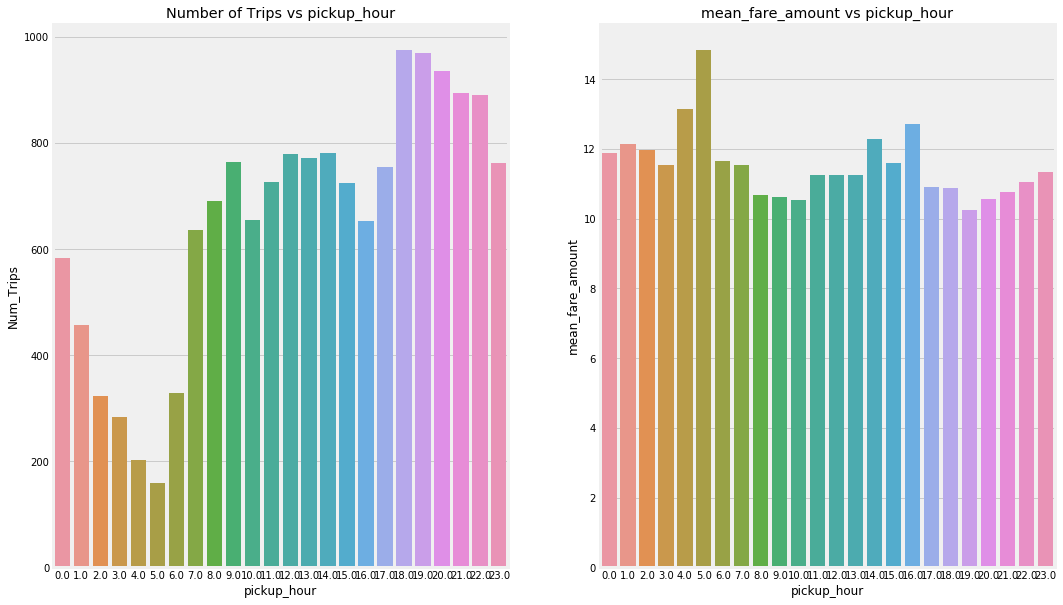

In [76]:
groupandplot(train,'pickup_hour','fare_amount')

The avg fare amount at 5pm is the higher while the number of trips at 5 am are on an average. The number of trips are highest in 18 and 19 hours

In [77]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

### How does Number of passengers affect Fare Amount

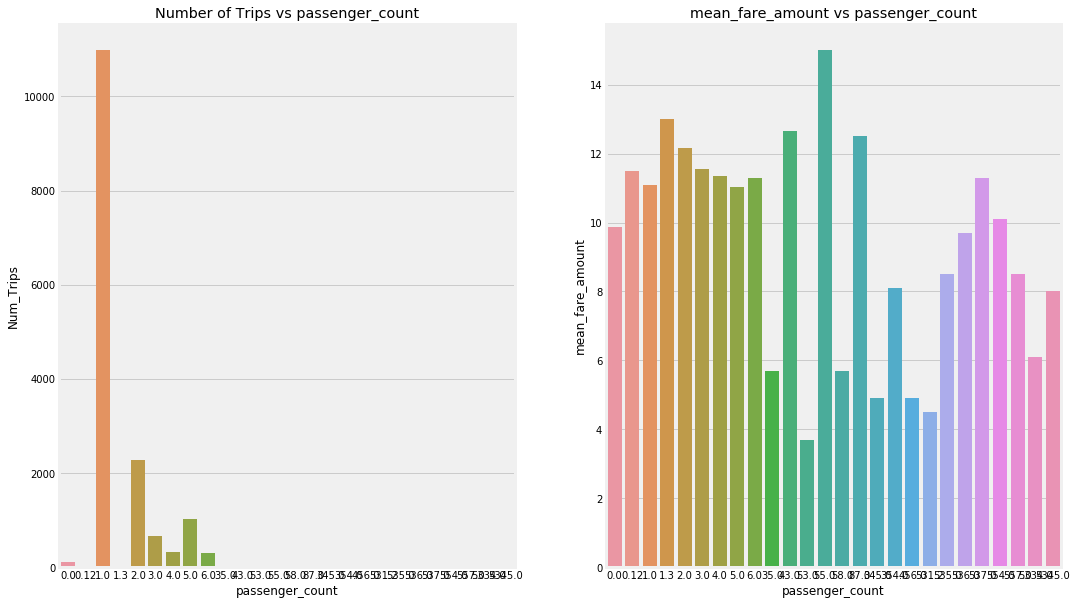

In [78]:
groupandplot(train,'passenger_count','fare_amount')

In [79]:
train.loc[train['passenger_count'] <= 0].shape

(110, 28)

In [80]:
train.loc[train['passenger_count'] > 9].shape

(18, 28)

There are trips with 0 passengers as well. In these cases are drop and pickup location the same? If so it would mean that passenger didnt take the cab after the cab arrived and a cancellation fee was charged
The fare is very high when there are 2 passengers.


Pending on me .............................................................................

In [81]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(train.loc[train['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers 1.8591997298957221


In [82]:
train=train[train['passenger_count']<=8]

In [83]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15684 entries, 0 to 15701
Data columns (total 28 columns):
fare_amount                   15684 non-null float64
pickup_datetime               15684 non-null object
pickup_longitude              15684 non-null float64
pickup_latitude               15684 non-null float64
dropoff_longitude             15684 non-null float64
dropoff_latitude              15684 non-null float64
passenger_count               15684 non-null float64
pickup_date                   15684 non-null object
pickup_day                    15684 non-null float64
pickup_hour                   15684 non-null float64
pickup_day_of_week            15684 non-null int64
pickup_month                  15684 non-null float64
pickup_year                   15684 non-null float64
pickup_latitude_round3        15684 non-null float64
pickup_longitude_round3       15684 non-null float64
dropoff_latitude_round3       15684 non-null float64
dropoff_longitude_round3      15684 non-null fl

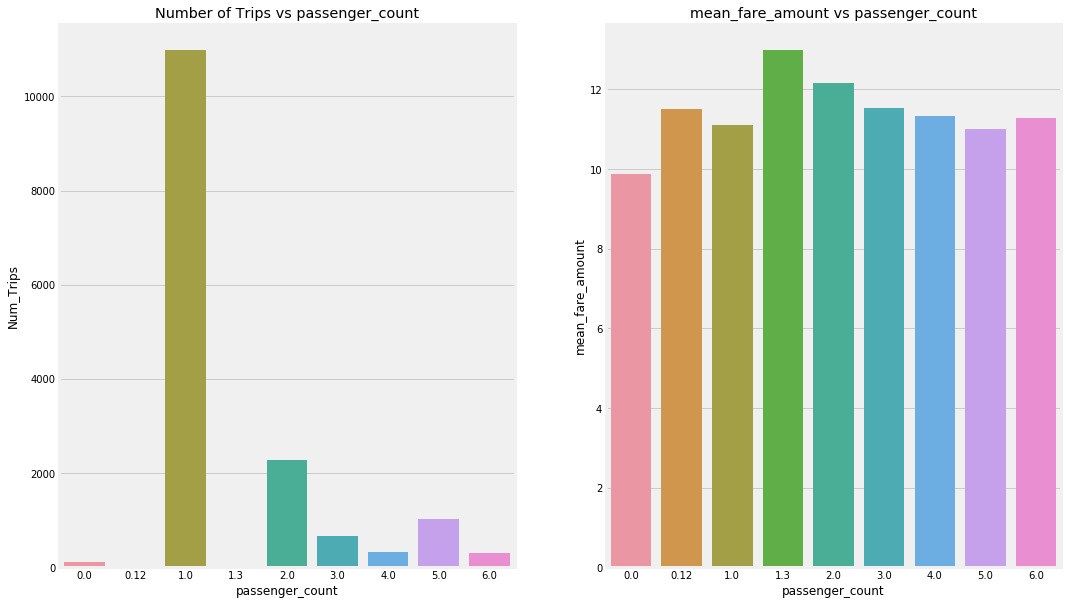

In [84]:
groupandplot(train,'passenger_count','fare_amount')

In [85]:
train.to_csv("train_cleaned.csv",index=False)

In [86]:
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['is_pickup_JFK']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
test['is_pickup_EWR']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_la_guardia']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_la_guardia']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['is_pickup_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['is_dropoff_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['pickup_day_of_week']=test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
print("Shape of test data", test.shape)

test.to_csv("test_cleaned.csv",index=False)

Shape of test data (9914, 27)


# Modelling

In [87]:
import statsmodels.api as sm

In [88]:
train = pd.read_csv('train_cleaned.csv')
test = pd.read_csv('test_cleaned.csv')
print("Shape of Training Data ",train.shape)
print("Shape of Testing Data ",test.shape)

Shape of Training Data  (15684, 28)
Shape of Testing Data  (9914, 27)


#### Pre-Processing data

    1.Remove the unwanted columns like pickup_datetime, pickup_date, latitude and longitude rounded to 3 decimal places.
    2.One hot encoding of categorical variables
    3.Divide training data into train and validation datasets - 80% training and 20% validation

In [89]:
drop_columns=['pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']

In [90]:
train_1=train.drop(drop_columns,axis=1)
test_1=test.drop(drop_columns,axis=1)
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (15684, 22)
Shape of Testing Data after dropping columns (9914, 21)


In [91]:
train_1=pd.get_dummies(train_1)
test_1=pd.get_dummies(test_1)

print("Shape of Training Data after One Hot Encoding",train_1.shape)
print("Shape of Testing Data after One Hot Encoding",test_1.shape)

Shape of Training Data after One Hot Encoding (15684, 32)
Shape of Testing Data after One Hot Encoding (9914, 31)


In [92]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']

In [93]:
#split data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])

Number of records in training data  12547
Number of records in validation data  3137


#### 1.Linear Regression

In [94]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
#import xgboost as xgb
import operator
import pickle
import os

In [95]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  5.416287750531887


In [96]:
linear_reg_pred=lm.predict(test_1)

In [97]:
test['fare_amount']= linear_reg_pred

In [98]:
test.to_csv("LinearRegression.csv",index=False)

#### 2. Logistic regression

As we can see in the problem our Target variable (fare_amount) is not categorical. Hence Logistic regression doesnot apply.

#### 3. Decision Tree

In [99]:
from sklearn.tree import DecisionTreeRegressor

In [100]:
train_1.shape

(15684, 32)

In [101]:
#Decision Tree for regression
dt = DecisionTreeRegressor(random_state=0)

In [102]:
dt

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [103]:
dt.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=0, splitter='best')

In [104]:
y_pred=dt.predict(X_test)
dt_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Decision Tree is ",dt_rmse)

RMSE for Decision Tree is  5.587597825904561


In [105]:
decision_tree_pred=dt.predict(test_1)

In [106]:
test['fare_amount']= decision_tree_pred

In [107]:
test.to_csv("DecisionTree.csv",index=False)

#### 4. Random Forest Model

In [108]:
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [109]:
rf_pred= rf.predict(X_test)
rf_rmse=np.sqrt(mean_squared_error(rf_pred, y_test))
print("RMSE for Random Forest is ",rf_rmse)

RMSE for Random Forest is  4.164724447893973


In [110]:
random_forest_pred=rf.predict(test_1)

In [111]:
test['fare_amount']= random_forest_pred

In [112]:
test.to_csv("Random_forest.csv",index=False)